In [2]:
import zipfile as zf
files = zf.ZipFile("/content/ImageNet-Datasets-Downloader-master 2.zip", 'r')
files.extractall('ImageNet-Datasets-Downloader-master')
files.close()

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.datasets import ImageFolder

def train(model, iterator, optimizer, criterion):
    loss = 0
    acc = 0
    model.train()
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        accuracy = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        loss += loss.item()
        acc += accuracy
    return loss.detach().numpy() / len(iterator), acc / len(iterator)

def evaluate(model, iterator, criterion, test_set):
    loss = 0
    acc = 0
    model.eval()
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            loss += loss.item()
            acc += acc
    if test_set== 1:
        return loss / len(iterator), acc / len(iterator), y_pred, y
    else:
        return loss / len(iterator), acc / len(iterator)


def calculate_accuracy(y_pred, y):
    _, topk_predictions = torch.topk(y_pred, 2)
    correct = 0
    for i in range(y.shape[0]):
        if y[i] in topk_predictions[i]:
            correct += 1
    accuracy = correct / y.shape[0]
    return accuracy

Number of training examples: 16
Number of validation examples: 2
Number of testing examples: 2


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 40s
	Train Loss: 0.171 | Train Acc: 70.07%
	 Val. Loss: 1.546 |  Val. Acc: 65.80%
	 Test. Loss: 1.541 |  Test. Acc: 65.67%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 40s
	Train Loss: 0.207 | Train Acc: 64.89%
	 Val. Loss: 1.602 |  Val. Acc: 63.64%
	 Test. Loss: 1.545 |  Test. Acc: 64.38%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 40s
	Train Loss: 0.190 | Train Acc: 66.61%
	 Val. Loss: 1.604 |  Val. Acc: 65.37%
	 Test. Loss: 1.616 |  Test. Acc: 65.24%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 42s
	Train Loss: 0.201 | Train Acc: 64.50%
	 Val. Loss: 1.659 |  Val. Acc: 62.77%
	 Test. Loss: 1.654 |  Test. Acc: 62.66%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 40s
	Train Loss: 0.210 | Train Acc: 64.76%
	 Val. Loss: 1.651 |  Val. Acc: 62.34%
	 Test. Loss: 1.528 |  Test. Acc: 65.67%


Training:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Validation loss has not improved for 5 epochs. Early stopping.


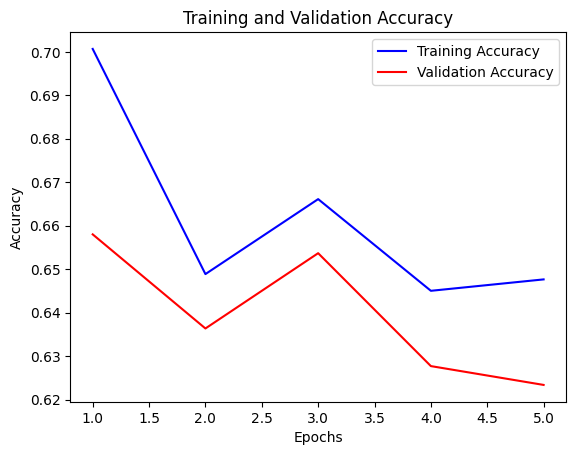

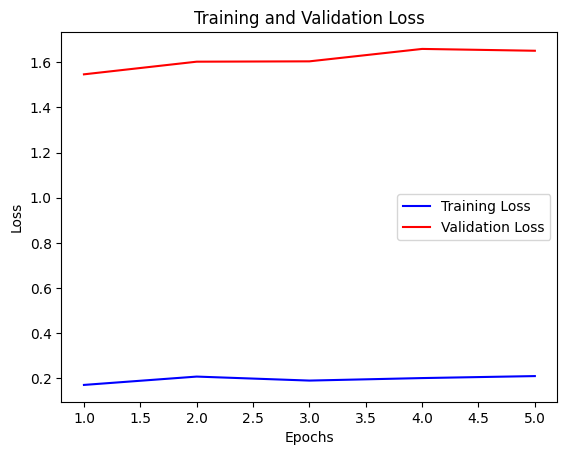

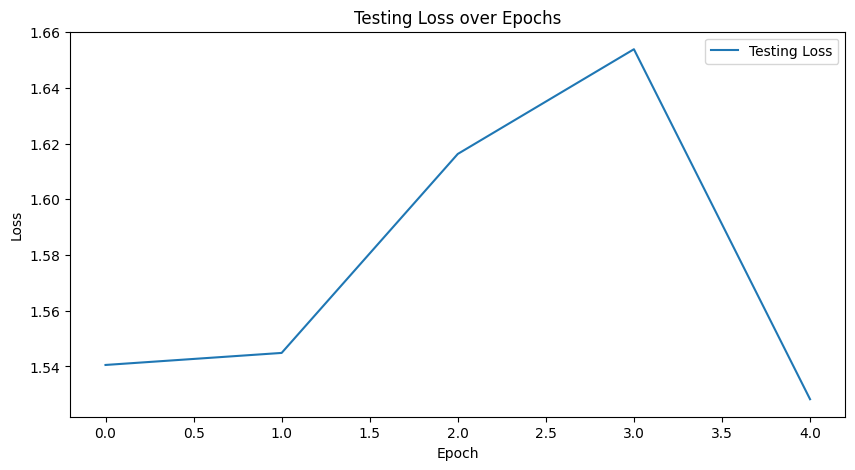

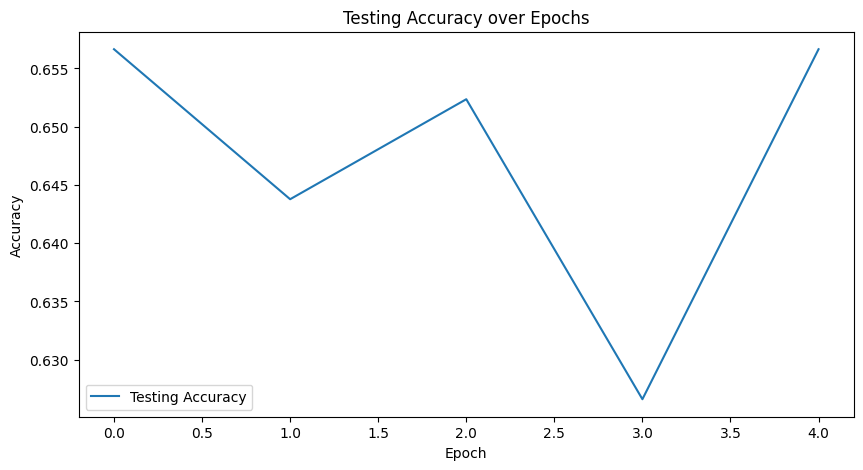

Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]

Precision: 0.5091147714372867
Recall: 0.505897242923105
F1 Score: 0.4990558770126093


<Figure size 500x500 with 0 Axes>

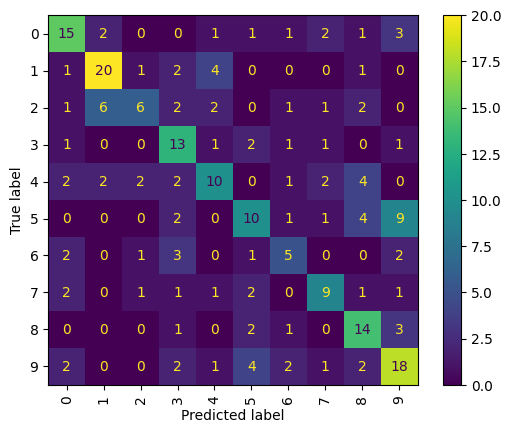

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 2, 1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 192, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 384, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

OUTPUT_DIM = 10
model = AlexNet(OUTPUT_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8, weight_decay=0.001)
num_epochs = 100
transform = transforms.Compose([
       transforms.RandomHorizontalFlip(0.2),
                           transforms.RandomCrop(32, padding=2),
                           transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
root_dir = "/content/ImageNet-Datasets-Downloader-master/ImageNet-Datasets-Downloader-master/data_root_folder/imagenet"
dataset = ImageFolder(root=root_dir, transform=transform)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
num_samples = len(dataset)
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size
training_accuracy , testing_accuracy , validation_accuracy = [], [], []
training_loss , testing_loss , validation_loss = [], [], []
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
batch = 256
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False)
print(f'Number of training examples: {len(train_loader)}')
print(f'Number of validation examples: {len(val_loader)}')
print(f'Number of testing examples: {len(test_loader)}')
EPOCHS = 100
best_valid_loss = float('inf')
patience = 5
no_improvement_count = 0
model.load_state_dict(torch.load('/content/ImageNet-Datasets-Downloader-master/ImageNet-Datasets-Downloader-master/image.pt'))

for epoch in trange(EPOCHS, desc="Epochs"):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, val_loader, criterion,0)
    test_loss, test_acc = evaluate(model, test_loader, criterion,0)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        no_improvement_count = 0
        torch.save(model.state_dict(), '/content/ImageNet-Datasets-Downloader-master/ImageNet-Datasets-Downloader-master/image.pt')
    else:
        no_improvement_count += 1
    if no_improvement_count >= patience:
        print(f'Validation loss has not improved for {patience} epochs. Early stopping.')
        break
    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')
    training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)
    validation_accuracy.append(valid_acc)
    training_loss.append(train_loss)
    testing_loss.append(test_loss)
    validation_loss.append(valid_loss)


epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_train_val.png')
plt.show()

epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_train_val.png')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(testing_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Testing Loss over Epochs')
plt.legend()
plt.savefig('loss_test.png')
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(testing_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Testing Accuracy over Epochs')
plt.legend()
plt.savefig('accuracy_test.png')
plt.show()

test_loss, test_acc,y_pred,y_true= evaluate(model, test_loader, criterion, 1)
y_pred = y_pred.argmax(1, keepdim=True)
cm = confusion_matrix(y_true.tolist(), y_pred.tolist())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(5,5))
disp.plot()
plt.xticks(rotation=90)
plt.savefig('confusion_matrix')

precision = precision_score(y_true.tolist(), y_pred.tolist(),average='macro')
recall = recall_score(y_true.tolist(), y_pred.tolist(),average='macro')
f1 = f1_score(y_true.tolist(), y_pred.tolist(),average='macro')
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)